# Project Category Identification NLP Project <a id='Data Overview'></a>

## Table of Contents <a id='2.1_Contents'></a>
* [0. Background](#0)
    * [0.1 Import Libraries](#0.1)
    * [0.2 Import Original Dataset ](#0.2)
* [1. Data Wrangling](#1)
    * [1.1 Data Exploration ](#1.1)
        * [1.1.1 Data Exploration - client_name](#1.1.1)
        * [1.1.2 Data Exploration - bid_type](#1.1.2)
        * [1.1.3 Data Exploration - bid_classification](#1.1.3)
        * [1.1.4 Data Exploration - bid_ID](#1.1.4)
        * [1.1.5 Data Exploration - Category](#1.1.5)
        * [1.1.6 Remove Columns](#1.1.6)
    * [1.2 Data Cleaning](#1.2)
        * [1.2.1 Category - Data Cleaning](#1.2.1)
        * [1.2.2 Category - Assign Number](#1.2.2)
        * [1.2.3 bid_type - Data Cleaning](#1.2.3)
        * [1.2.4 project_name - Data Cleaning](#1.2.4)
* [2. Exploratory Data Analysis ](#2)
    * [2.1 Character Counts](#2.1)
    * [2.2 Words Counts](#2.2)
    * [2.3 Average Words Length](#2.3)
    * [2.4 Most Frequent words - Stopwords](#2.4)
    * [2.5 Most Frequent words - Counter Words](#2.5)
    * [2.6 Bigrams](#2.6)
    * [2.7 Tri-grams ](#2.7)
    * [2.8 Wordcloud - Overall ](#2.8)
    * [2.9 Wordcloud by Category](#2.9)
    * [2.10 Wordcloud by type](#2.10)
* [3. Pre-processing and Training Data Development](#3)
    * [3.1 Lemmatization and Stopwords Removal](#3.1)
* [4. Training](#4)
    * [4.1 Logistic Regression ](#4.1)
        * [4.1.1 Logistic Regression Hyperparameters Tuning - with Feature Reduction](#4.1.1)
        * [4.1.2 Logistic Regression Hyperparameters Tuning - without Feature Reduction ](#4.1.2)
    * [4.2 Random Forest Model](#4.2)
        * [4.2.1 Random Forest Model Hyperparameters Tuning](#4.2.1)
* [5. Modeling](#5)
* [6. Conclusion](#6)

## 0. Background <a id='0'></a>

I built a web scrapping tool that scraps biding and tendering information from public sectors in Ontario. The public sectors includes regions such as York Region, Peel Region, Halton Region, and cities such as City of Mississauga.

The intend of the project is to use DATA to tell a story about the Competitiveness of the public sector. The collected information are used to conduct the following analysis:

* **Public Sector Market Understanding**: an overview of the public sector markets (services, construction, and goods), how the market changes over time.

* **Competitive Information**: an overview of the performance of private companies in different public sectors. What is their wining rate comparing with their competitors. The private companies includes construction companies such as Maple Reinders Constructors Ltd. and Kenaidan Contracting Ltd., consulting companies such WSP Canada Inc., Hatch Ltd., and good supplying companies.

* **Competitiveness by Category** Different private companies in the public sectors have overlapping skill sets in the public sectors, they may also specialize a niche that company leaders and strategist may not be aware off. The tool intends to use DATA to show competitiveness of each companies in different sectors such as consulting in water & wastewater, construction in civil engineering works, etc.

The collected information includes project names and a generic category information. In order to understand "Competitiveness by Category", the original "generic category" needs to further broken down into detailed categories. There are almost 10k project collected, it is not practical to provide a detailed category to each of the project,. Further more, as more projects be collected, manual tagging the category is timing consuming.

Therefore, Natural Language Processing (NLP) is used to do the category task for current projects and any future projects.

### 0.1 Import Libraries <a id='0.1'></a>

In [110]:
import pandas as pd
import numpy as np
import datacleaning as datacleaning
import string
import re

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import spacy
import scipy.sparse
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

### 0.2 Import Original Dataset <a id='0.2'></a>

In [111]:
path = "../NaturalLanguageProcessing/DataUpdate.csv"
df = pd.read_csv(path)
df.drop_duplicates(inplace=True)

## 1. Data Wrangling <a id='1'></a>

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7246 entries, 0 to 7245
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          7246 non-null   int64 
 1   client_name         7246 non-null   object
 2   project_name        7246 non-null   object
 3   Category            2591 non-null   object
 4   bid_classification  7246 non-null   object
 5   bid_type            7246 non-null   object
 6   bid_ID              7246 non-null   object
 7   awarded_date        7246 non-null   object
 8   awarded_year        7246 non-null   int64 
 9   company_name        7246 non-null   object
dtypes: int64(2), object(8)
memory usage: 622.7+ KB


In [113]:
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

client_name                                       project_name  \
0  Brant County  1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...   
1  Brant County               1 (One) Seven (7) Passenger Mini-Van   
2  Brant County            1 (One) Seven (7) Passenger Van / Wagon   
3  Brant County  1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck   
4  Brant County        1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck   

            Category bid_classification bid_type         bid_ID  \
0  Producer/Supplier              Goods      RFQ  OPS-RFQ-20-07   
1  Producer/Supplier              Goods      RFQ  OPS-RFQ-20-04   
2  Producer/Supplier              Goods      RFQ  OPS-RFQ-20-10   
3  Producer/Supplier              Goods      RFQ  OPS-RFQ-20-08   
4  Producer/Supplier              Goods      RFQ  OPS-RFQ-20-09   

      awarded_date  awarded_year  \
0  2021-03-26 0:00          2020   
1  2021-03-26 0:00          2020   
2  2021-03-26 0:00          2020   
3  2021-03-26 0:00          2020   
4  2021-03-26 0:00          2020   

                                        company_name  
0  Finch Auto Group       GORD ANDERSON AUTOMOTIV...  
1            Oxford Dodge Chrysler (1992) LTD         
2  East Court Ford Lincoln       Oxford Dodge Chr...  
3  Finch Auto Group       GORD ANDERSON AUTOMOTIV...  
4  East Court Ford Lincoln       Finch Auto Group...

### 1.1 Data Exploration <a id='1.1'></a>

#### 1.1.1 Data Exploration - client_name <a id='1.1.1'></a>

In [114]:
client_list = df.client_name.unique().tolist()
len(client_list)

19

In [115]:
client_list

['Brant County',
 'City Of Peterborough',
 'City of Barrie',
 'City of Brantford',
 'City of Guelph',
 'City of Hamilton',
 'City of Kawartha Lakes',
 'City of London',
 'City of Orillia',
 'Dufferin County',
 'Durham Region',
 'Haldimand County',
 'Halton Region',
 'Niagara Region',
 'Peel Region',
 'Peterborough County',
 'Simcoe County',
 'Waterloo Region',
 'York Region']

<AxesSubplot:>

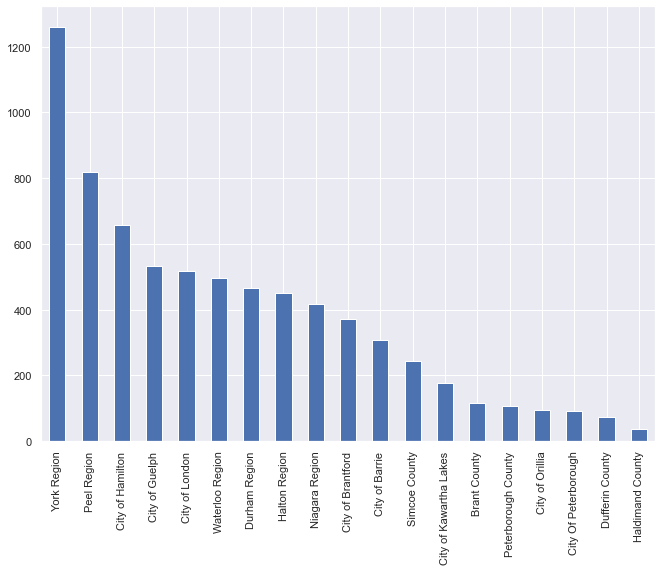

In [116]:
df.client_name.value_counts().plot.bar()

There are 19 clients included in the dataset. The client name will not be used as an input for NLP because the client name does not have any affect on the project name and project category.York Region has a good record of their public projects online.

#### 1.1.2 Data Exploration - bid_type <a id='1.1.2'></a>

There are a couple of bid types in the business of the public sector: Request for Tender(RFT), Request for Proposal(RFP), Request for Quotation(RFQ), Request for Information (RFI), and Request for Pre-Qualification(RFPQ).

In [117]:
df.bid_type.describe()

count     7246
unique      58
top        RFT
freq      1207
Name: bid_type, dtype: object

In [118]:
df.bid_type.unique().tolist()

['RFQ',
 'Tender',
 'RFP',
 'ITT',
 'RFSQ',
 'RFQ – High Score',
 'RFQ – Low Bid',
 'RFP – Consecutive Negotiation',
 'Non-Standard Procurement',
 'RFSQ – Prequalification',
 'Notice',
 'RFT',
 'RFQ (<)',
 'RFD (Disposal)',
 'RFPQ',
 'RFRC',
 'RFP - Revenue Generating',
 'RFP - Goods and Services',
 'RFP - Prime Consultant',
 'RFT - Construction - Stipulated Price - CCDC',
 'RFT - Public Works',
 'RFT - Construction - Unit Price',
 'RFT - Goods and Services',
 'RFT - Revenue Generating',
 'RFT - Vehicle',
 'Request For Quotation',
 'Request For Proposal',
 'Request For Supplier Qualification',
 'Request for Tender',
 'Request for Proposal',
 'Request for Qualifications',
 'Request for Quotation (Formal)',
 'Request for Information',
 'Informal Request for Quotation',
 'RFEOI',
 'Request for Supplier Pre-qualification',
 'Request For Quotations',
 'N',
 'NRFP',
 'Request For Tender',
 'Request For PreQualification',
 'Request for Proposal(N)',
 'DN',
 'VOR',
 'RFO',
 'Request for Offer'

In [119]:
df.bid_type.value_counts(dropna = False)

RFT                                             1207
Tender                                          1200
RFP                                             1188
Request for Tender                               671
RFQ                                              332
Request For Proposal                             295
Pre-Qualification                                223
Request For Quotation                            195
Request For Tender                               176
Request for Proposal                             176
RFT - Goods and Services                         157
RFT - Public Works                               152
RFPQ                                             123
RFP - Goods and Services                         104
RFQ – Low Bid                                    101
ITT                                               97
RFT - Construction - Stipulated Price - CCDC      91
Request for Quotation (Formal)                    85
RFP – Consecutive Negotiation                 

As we can see the bid types are not unified across different regions/cities, a hashmap is developed to revise values.

In [120]:
df.bid_type = df.bid_type.apply(lambda x : datacleaning.get_bidType(x))

In [121]:
df

client_name                                       project_name  \
0     Brant County  1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...   
1     Brant County               1 (One) Seven (7) Passenger Mini-Van   
2     Brant County            1 (One) Seven (7) Passenger Van / Wagon   
3     Brant County  1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck   
4     Brant County        1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck   
...            ...                                                ...   
7241   York Region  York Telecom Network Construction And Maintena...   
7242   York Region  York-Durham Line Concrete Box Culvert Replacem...   
7243   York Region  York-Peel 900Mm Twin Forcemains Combined Air R...   
7244   York Region  Yrt/Viva 2021-2025 Strategic Plan And 2017-202...   
7245   York Region                          Yrt/Viva Mapping Services   

                                    Category bid_classification  \
0                          Producer/Supplier              Goods   
1                          Producer/Supplier              Goods   
2                          Producer/Supplier              Goods   
3                          Producer/Supplier              Goods   
4                          Producer/Supplier              Goods   
...                                      ...                ...   
7241        Construction - Fibre Optic Cable              Goods   
7242                                     NaN       Construction   
7243  Construction - Water Wastewater Linear       Construction   
7244                                     NaN           Services   
7245          Consulting - Software Services           Services   

                        bid_type         bid_ID     awarded_date  \
0     Request for Quotation(RFQ)  OPS-RFQ-20-07  2021-03-26 0:00   
1     Request for Quotation(RFQ)  OPS-RFQ-20-04  2021-03-26 0:00   
2     Request for Quotation(RFQ)  OPS-RFQ-20-10  2021-03-26 0:00   
3     Request for Quotation(RFQ)  OPS-RFQ-20-08  2021-03-26 0:00   
4     Request for Quotation(RFQ)  OPS-RFQ-20-09  2021-03-26 0:00   
...                          ...            ...              ...   
7241     Request for Tender(RFT)       T-16-118           08-May   
7242     Request for Tender(RFT)         16-122           19-Aug   
7243     Request for Tender(RFT)       T-19-129           08-Jul   
7244   Request for Proposal(RFP)       P-15-189           24-May   
7245   Request for Proposal(RFP)       P-16-161           03-Jan   

      awarded_year                                       company_name  
0             2020  Finch Auto Group       GORD ANDERSON AUTOMOTIV...  
1             2020            Oxford Dodge Chrysler (1992) LTD         
2             2020  East Court Ford Lincoln       Oxford Dodge Chr...  
3             2020  Finch Auto Group       GORD ANDERSON AUTOMOTIV...  
4             2020  East Court Ford Lincoln       Finch Auto Group...  
...            ...                                                ...  
7241          2017  Aecon Utilities       Black & McDonald Limited...  
7242          2016  Primrose Contracting (Ont.) Inc.       Everstr...  
7243          2020  H2Ontario Inc.       Jeviso Construction Corpo...  
7244          2016  AECOM Canada Ltd.       Dillon Consulting Limi...  
7245          2017  Lets Bus It Publications Inc.       Lucidmap I...  

[7246 rows x 9 columns]

#### 1.1.3 Data Exploration - bid_classification <a id='1.1.3'></a>

In [122]:
df.bid_classification.unique()

array(['Goods', 'Construction', 'Services'], dtype=object)

In [123]:
df.bid_classification.value_counts(dropna = False)

Services        3381
Construction    2672
Goods           1193
Name: bid_classification, dtype: int64

There are three type of bid classification: "Services", "Construction", and "Goods".

#### 1.1.4 Data Exploration - bid_ID <a id='1.1.4'></a>

In [124]:
df.bid_ID.value_counts().sort_values(ascending=False)

C12-06-18    39
17-151        3
17-126        3
19-181        2
17-142        2
             ..
P-15-189      1
T-19-80       1
T-17-02       1
T-16-132      1
P-16-161      1
Name: bid_ID, Length: 7138, dtype: int64

In [125]:
df.bid_ID.unique().size

7138

Note that there are bid that have duplicates IDs.

#### 1.1.5 Data Exploration - Category <a id='1.1.5'></a>
This is the target, "Category" had been manually added to the dataset for the model analysis.

In [126]:
df.Category.value_counts().sort_values(ascending=False)

Producer/Supplier                            862
Consulting - Water Wastewater Vertical       297
Construction - Water Wastewater Linear       209
Construction - Road                          207
Construction - Water Wastewater Vertical     203
Consulting - Transportation Road/Trainsit    201
Consulting - Geotechnical/Environmental      147
Consulting - Water Wastewater Linear          97
Construction - Facility                       88
Consulting - Facility                         85
Consulting - Others                           65
Construction - Landscaping                    63
Consulting - Transportation Bridge            30
Consulting - Software Services                17
Construction - Fibre Optic Cable              13
Consulting - Landscaping                       6
Consulting- Geotechnical/Environmental         1
Name: Category, dtype: int64

In [127]:
df.Category = df.Category.replace({'Consulting- Geotechnical/Environmental' : "Consulting - Geotechnical/Environmental"})
df.Category.value_counts().sort_values(ascending=False)

Producer/Supplier                            862
Consulting - Water Wastewater Vertical       297
Construction - Water Wastewater Linear       209
Construction - Road                          207
Construction - Water Wastewater Vertical     203
Consulting - Transportation Road/Trainsit    201
Consulting - Geotechnical/Environmental      148
Consulting - Water Wastewater Linear          97
Construction - Facility                       88
Consulting - Facility                         85
Consulting - Others                           65
Construction - Landscaping                    63
Consulting - Transportation Bridge            30
Consulting - Software Services                17
Construction - Fibre Optic Cable              13
Consulting - Landscaping                       6
Name: Category, dtype: int64

We only want to include the rows that contains "Category" in our dataset.

#### 1.1.6 Remove Columns <a id='1.1.6'></a>

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7246 entries, 0 to 7245
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   client_name         7246 non-null   object
 1   project_name        7246 non-null   object
 2   Category            2591 non-null   object
 3   bid_classification  7246 non-null   object
 4   bid_type            7246 non-null   object
 5   bid_ID              7246 non-null   object
 6   awarded_date        7246 non-null   object
 7   awarded_year        7246 non-null   int64 
 8   company_name        7246 non-null   object
dtypes: int64(1), object(8)
memory usage: 566.1+ KB


In [129]:
df.head(5)

client_name                                       project_name  \
0  Brant County  1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...   
1  Brant County               1 (One) Seven (7) Passenger Mini-Van   
2  Brant County            1 (One) Seven (7) Passenger Van / Wagon   
3  Brant County  1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck   
4  Brant County        1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck   

            Category bid_classification                    bid_type  \
0  Producer/Supplier              Goods  Request for Quotation(RFQ)   
1  Producer/Supplier              Goods  Request for Quotation(RFQ)   
2  Producer/Supplier              Goods  Request for Quotation(RFQ)   
3  Producer/Supplier              Goods  Request for Quotation(RFQ)   
4  Producer/Supplier              Goods  Request for Quotation(RFQ)   

          bid_ID     awarded_date  awarded_year  \
0  OPS-RFQ-20-07  2021-03-26 0:00          2020   
1  OPS-RFQ-20-04  2021-03-26 0:00          2020   
2  OPS-RFQ-20-10  2021-03-26 0:00          2020   
3  OPS-RFQ-20-08  2021-03-26 0:00          2020   
4  OPS-RFQ-20-09  2021-03-26 0:00          2020   

                                        company_name  
0  Finch Auto Group       GORD ANDERSON AUTOMOTIV...  
1            Oxford Dodge Chrysler (1992) LTD         
2  East Court Ford Lincoln       Oxford Dodge Chr...  
3  Finch Auto Group       GORD ANDERSON AUTOMOTIV...  
4  East Court Ford Lincoln       Finch Auto Group...

In [130]:
# columns to be removed, as they are not contribute to the category results
columns = ['client_name', 'bid_ID', 'awarded_date', 'awarded_year', 'bid_classification', 'company_name']
df = df.drop(columns=columns)

### 1.2 Data Cleaning <a id='1.2'></a>

The category of the projects were manually added by me. We will ignore all the rows that missing category information.

In [131]:
df = df.dropna(subset=['Category'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2591 entries, 0 to 7245
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   project_name  2591 non-null   object
 1   Category      2591 non-null   object
 2   bid_type      2591 non-null   object
dtypes: object(3)
memory usage: 81.0+ KB


In [132]:
df.head()

project_name           Category  \
0  1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...  Producer/Supplier   
1               1 (One) Seven (7) Passenger Mini-Van  Producer/Supplier   
2            1 (One) Seven (7) Passenger Van / Wagon  Producer/Supplier   
3  1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck  Producer/Supplier   
4        1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck  Producer/Supplier   

                     bid_type  
0  Request for Quotation(RFQ)  
1  Request for Quotation(RFQ)  
2  Request for Quotation(RFQ)  
3  Request for Quotation(RFQ)  
4  Request for Quotation(RFQ)

#### 1.2.1 Category - Data Cleaning <a id='1.2.1'></a>

Category is our target. We have 17 category of data. We have around 2500 data points for our study.It is likely that we may not have a good accuracy of the data based on the sample size. We want to think some strategies to shrink 17 category further down into boarder categories.

After some considerations, it is hard to to shrink down the categories, a soft shrink strategy is applied.

In [133]:
category_list = df.Category.unique().tolist()
category_list.sort()
category_list

['Construction - Facility',
 'Construction - Fibre Optic Cable',
 'Construction - Landscaping',
 'Construction - Road',
 'Construction - Water Wastewater Linear',
 'Construction - Water Wastewater Vertical',
 'Consulting - Facility',
 'Consulting - Geotechnical/Environmental',
 'Consulting - Landscaping',
 'Consulting - Others',
 'Consulting - Software Services',
 'Consulting - Transportation Bridge',
 'Consulting - Transportation Road/Trainsit',
 'Consulting - Water Wastewater Linear',
 'Consulting - Water Wastewater Vertical',
 'Producer/Supplier']

<AxesSubplot:>

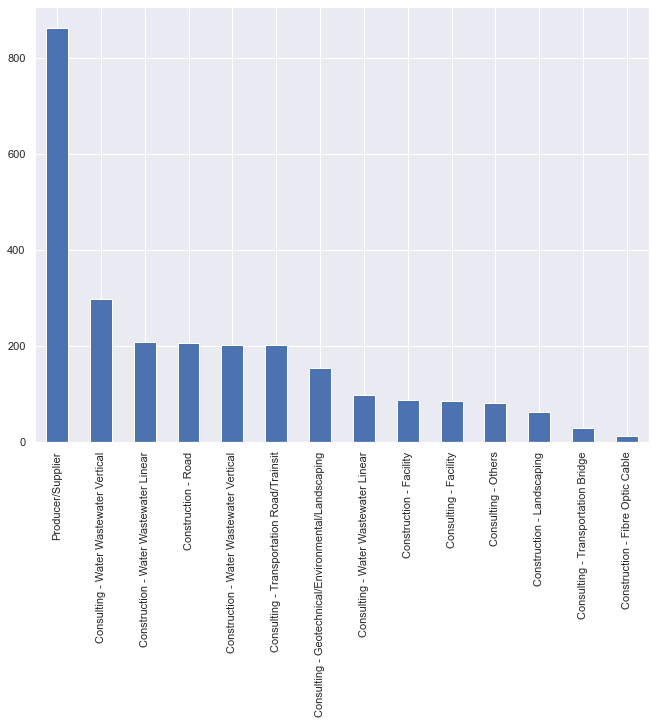

In [134]:
df.Category = df.Category.apply(lambda x : datacleaning.get_category(x))
df.Category.value_counts().plot.bar()

Note that we have lots of "Producer/Supplier", when we split the data, we have to make sure we this category will not affect the results due to large sample size - imbalanced data.

##### 1.2.2 Category - Assign Number <a id='1.2.2'></a>

<AxesSubplot:>

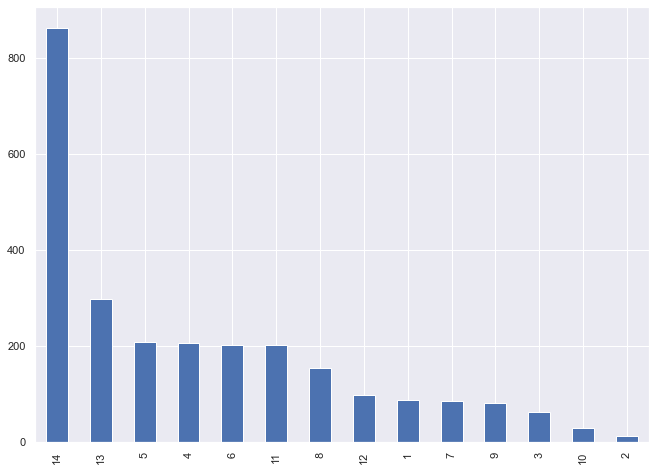

In [135]:
bid_category_numbering = {'Construction - Facility': 1,
                          'Construction - Fibre Optic Cable': 2,
                          'Construction - Landscaping': 3,
                          'Construction - Road': 4,
                          'Construction - Water Wastewater Linear': 5,
                          'Construction - Water Wastewater Vertical': 6,
                          'Consulting - Facility': 7,
                          'Consulting - Geotechnical/Environmental/Landscaping': 8,
                          'Consulting - Others': 9,
                          'Consulting - Transportation Bridge': 10,
                          'Consulting - Transportation Road/Trainsit': 11,
                          'Consulting - Water Wastewater Linear': 12,
                          'Consulting - Water Wastewater Vertical': 13,
                          'Producer/Supplier': 14
                          }
bid_category_numbering_reverse = {v: k for k, v in bid_category_numbering.items()}
df.Category = df.Category.apply(lambda x : bid_category_numbering.get(x))
df.Category.value_counts().plot.bar()

#### 1.2.3 bid_type - Data Cleaning <a id='1.2.3'></a>

In [136]:
df.bid_type.value_counts()

Request for Tender(RFT)                1209
Request for Proposal(RFP)               799
Request for Pre-Qualification(RFPQ)     257
Request for Quotation(RFQ)              232
Request for Information (RFI)            52
Others                                   42
Name: bid_type, dtype: int64

Note that almost all type has "Request for". This is not useful too much in terms of determine what category the project should belong to. Hence, only the information the round bracket.
1. lower case the string
2. if the string contains "()", then only include the information in the ()

In [137]:
def bid_type_cleaning(data):
    data = data.lower()
    temp_string = ''
    if '(' in data:
        data_list = data.split('(')
        temp_string = data_list[1].strip()
        temp_string = temp_string.replace(')', '')
        data = temp_string
    
    return data

In [138]:
df.bid_type = df.bid_type.apply(lambda x : bid_type_cleaning(x))

In [139]:
df.bid_type.value_counts()

rft       1209
rfp        799
rfpq       257
rfq        232
rfi         52
others      42
Name: bid_type, dtype: int64

####  1.2.4 project_name - Data Cleaning <a id='1.2.4'></a>

In [140]:
df.project_name.head(10)

0    1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...
1                 1 (One) Seven (7) Passenger Mini-Van
2              1 (One) Seven (7) Passenger Van / Wagon
3    1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck
4          1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck
5          1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck
6                   2 (Two) ¾ Ton 2Wd Cargo Style Vans
7                     2 Willow Street - Left Turn Lane
8                      2018 Detailed Condition Surveys
9                         2019 Poplar Hills Playground
Name: project_name, dtype: object

In [141]:
df.project_name[100:120]

220                           Agenda Management Software
222                               Alternative Fuel Study
223       Anne Street And Letitia Watermain Improvements
224    Anne Street/Highway 400 Watermain Crossing Aba...
225                   Annual Curb & Sidewalk Maintenance
226                Annual Groundwater Monitoring Program
228                          Asphalt Resurfacing Program
229        Asphalt, Curb And Sidewalk Maintenance - 2018
233    Bayfield Street Resurfacing From Cundles Road ...
234    Bayfield Street Water Tower - New Internal Lin...
235        Bcry Short Line Rail Market Feasibility Study
236                        Bell Farm Road Reconstruction
241                        Cipp Watermain Lining Program
245               City Wide Cycling Network Improvements
248    Community Energy And Greenhouse Gas Reduction ...
249              Comprehensive Transit Technology Review
252    Construction Inspection Services For Watermain...
254    Consulting Engineering S

Base on observation of the project's name, the follow data cleaning will be conducted:
1. lower case the entire string.
2. remove "()" and any content within them.
3. remove all punctuation marks (case: within in words, case: not included in words)

In [142]:
def project_name_cleaning(data):
    data = data.strip()
    data = data.lower()
    data = re.sub(r'[^a-zA-Z0-9\s]+', '', data)
    data = re.sub(' +', ' ', data)
    
    return data

df.project_name = df.project_name.apply(lambda x : project_name_cleaning(x))

In [143]:
df.project_name.head()

0    1 one 1 ton heavy duty 4wd cab and chassis tru...
1                      1 one seven 7 passenger minivan
2                    1 one seven 7 passenger van wagon
3        1 one ton 8 cyl standard cab 2wd pickup truck
4              1 one ton 4wd standard cab pickup truck
Name: project_name, dtype: object

In [144]:
df.project_name[100:120]

220                           agenda management software
222                               alternative fuel study
223       anne street and letitia watermain improvements
224    anne streethighway 400 watermain crossing aban...
225                     annual curb sidewalk maintenance
226                annual groundwater monitoring program
228                          asphalt resurfacing program
229           asphalt curb and sidewalk maintenance 2018
233    bayfield street resurfacing from cundles road ...
234    bayfield street water tower new internal liner...
235        bcry short line rail market feasibility study
236                        bell farm road reconstruction
241                        cipp watermain lining program
245               city wide cycling network improvements
248    community energy and greenhouse gas reduction ...
249              comprehensive transit technology review
252    construction inspection services for watermain...
254    consulting engineering s

## 2. Exploratory Data Analysis <a id='2'></a>

### 2.1 Character Counts <a id='2.1'></a>

<AxesSubplot:>

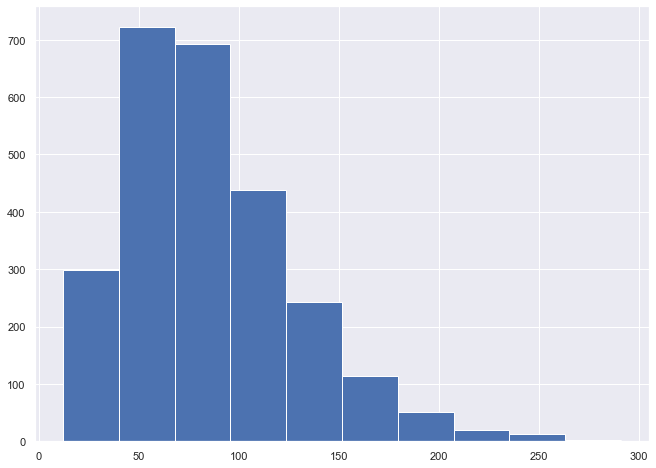

In [145]:
df.project_name.str.len().hist()

The histogram shows that the project name headlines range from 20 - 290. Generally, it is between 50 - 100 characters.

### 2.2 Words Counts <a id='2.2'></a>

<AxesSubplot:>

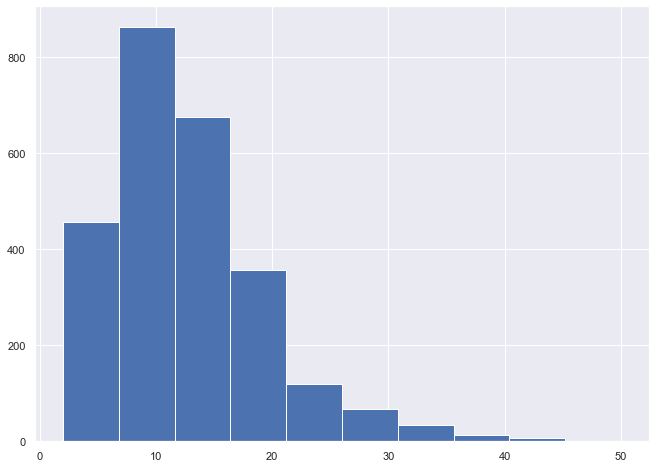

In [146]:
df.project_name.str.split().map(lambda x: len(x)).hist()

It is interesting to see that generally the words in the project name range from 2 to 20, but there are projects with longer names.

### 2.3 Average Words Length <a id='2.3'></a>

<AxesSubplot:>

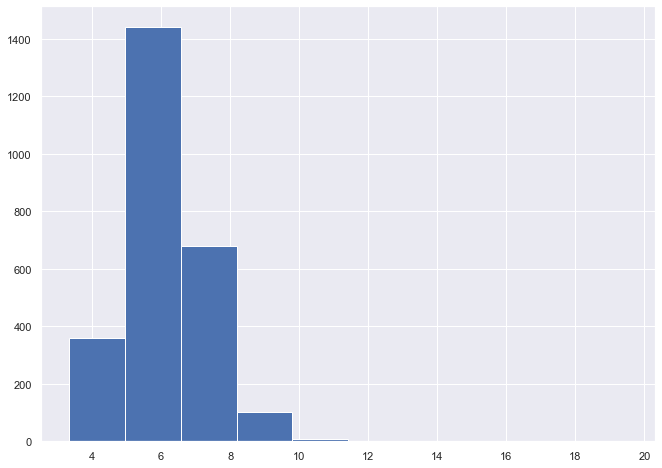

In [147]:
df.project_name.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### 2.4 Most Frequent words - Stopwords <a id='2.4'></a>

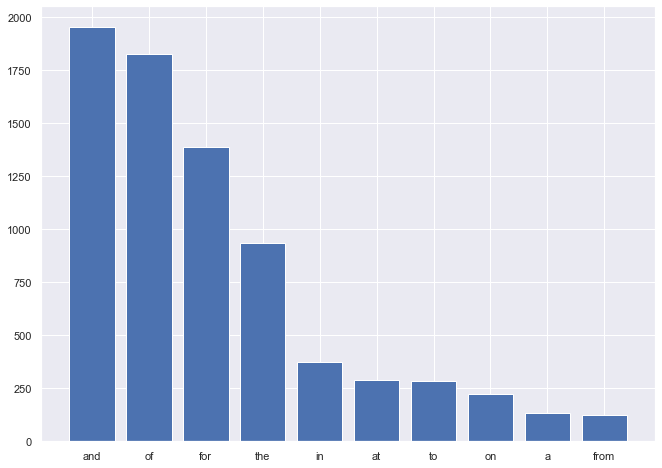

In [148]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    project = text.str.split()
    project = project.values.tolist()
    corpus = [word for i in project for word in i]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
plot_top_stopwords_barchart(df.project_name)

### 2.5 Most Frequent words - Counter Words <a id='2.5'></a>

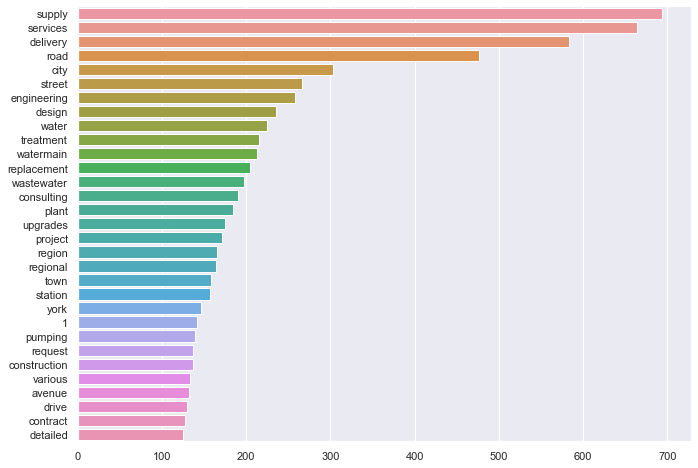

In [149]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    sns.set(rc={'figure.figsize':(11,8)})
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)


plot_top_non_stopwords_barchart(df.project_name)

### 2.6 Bigrams <a id='2.6'></a>

In [150]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

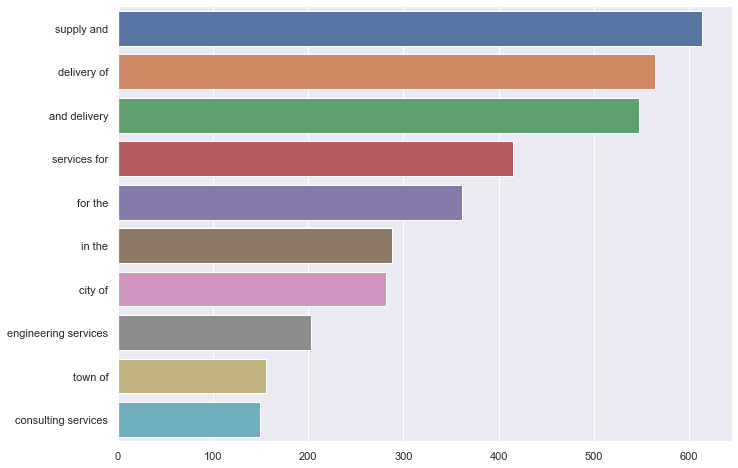

In [151]:
plot_top_ngrams_barchart(df.project_name,2)

### 2.7 Tri-grams <a id='2.6'></a>

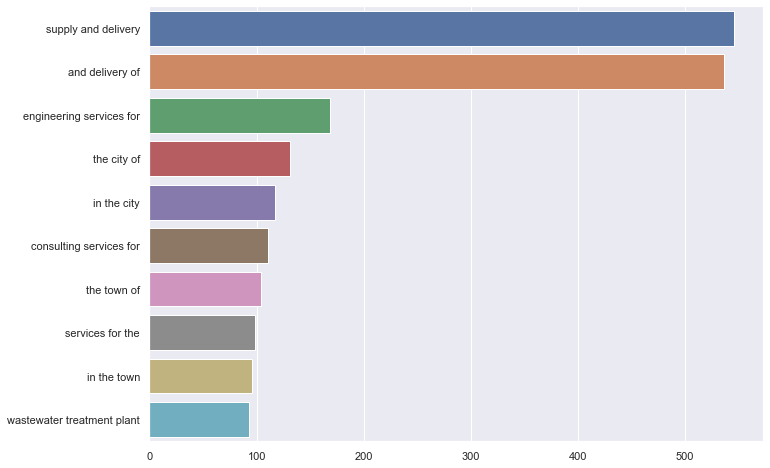

In [152]:
plot_top_ngrams_barchart(df.project_name,3)

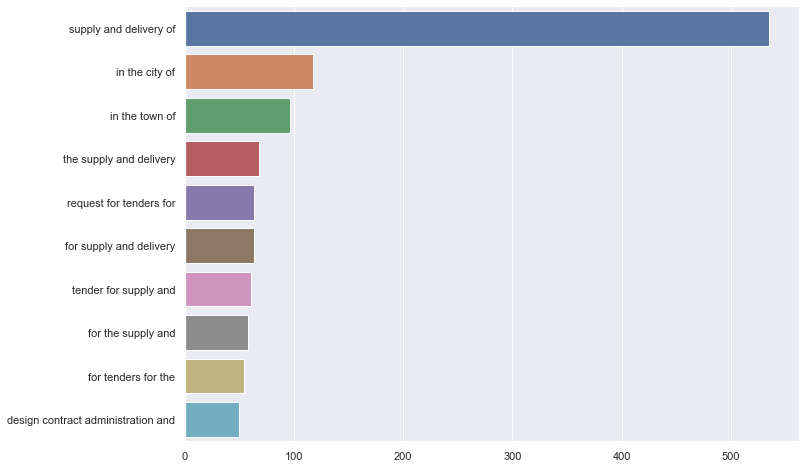

In [153]:
plot_top_ngrams_barchart(df.project_name,4)

### 2.8 Wordcloud - Overall  <a id='2.8'></a>

In [154]:
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        colormap="Dark2",
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=50, 
        scale=5,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

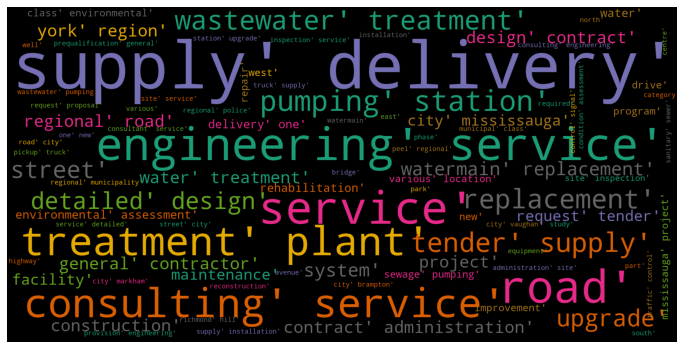

In [155]:
plot_wordcloud(df.project_name)

### 2.9 Wordcloud by Category <a id='2.9'></a>

Producer/Supplier


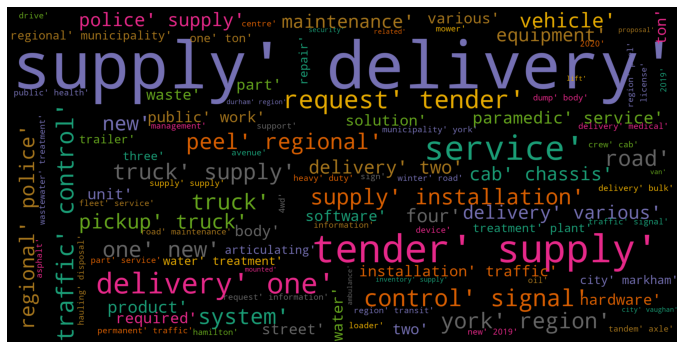

Construction - Road


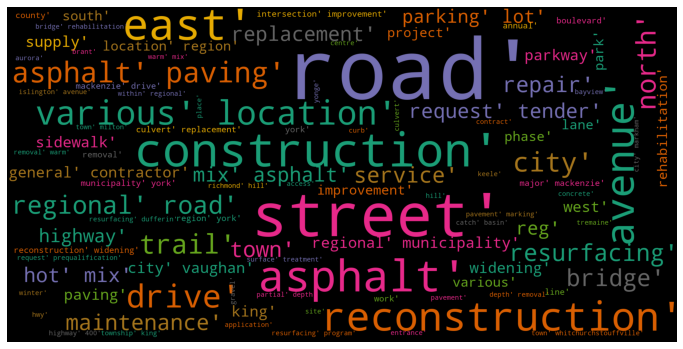

Consulting - Transportation Bridge


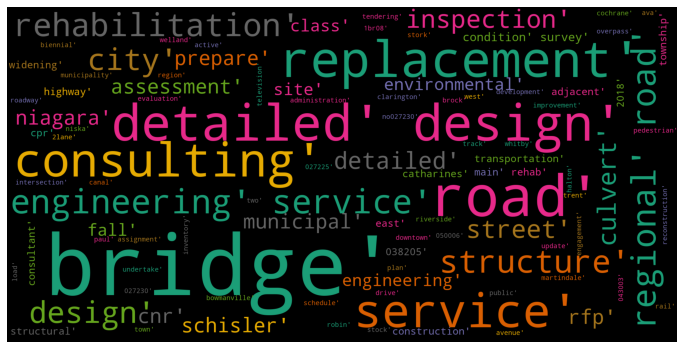

Construction - Landscaping


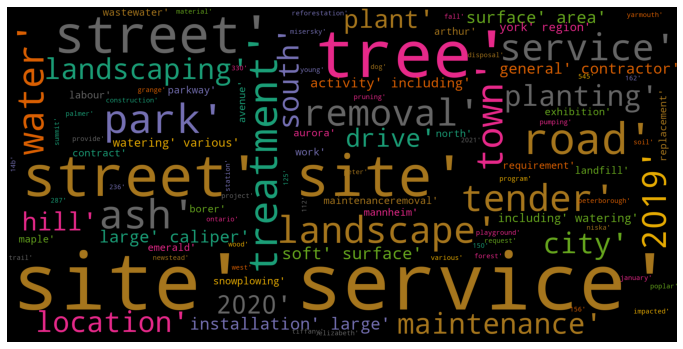

Construction - Water Wastewater Linear


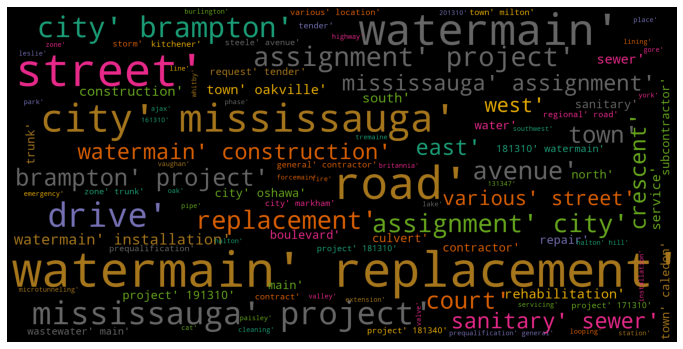

Consulting - Facility


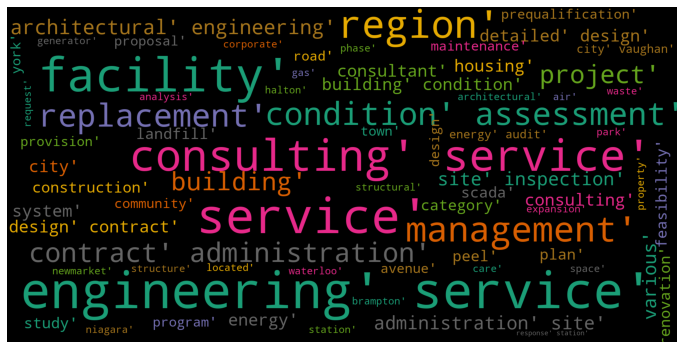

Consulting - Water Wastewater Linear


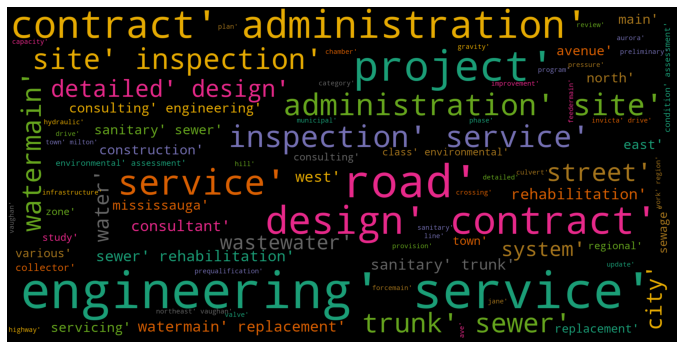

Consulting - Geotechnical/Environmental/Landscaping


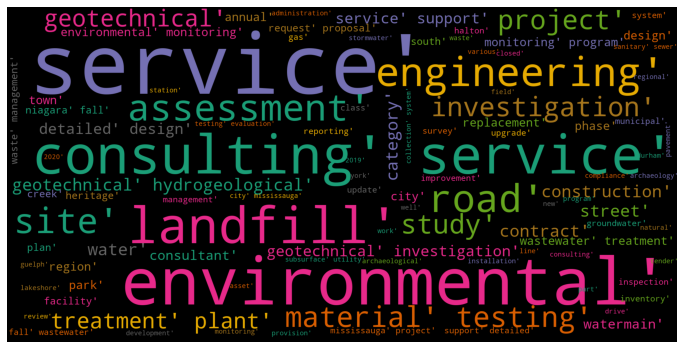

Construction - Water Wastewater Vertical


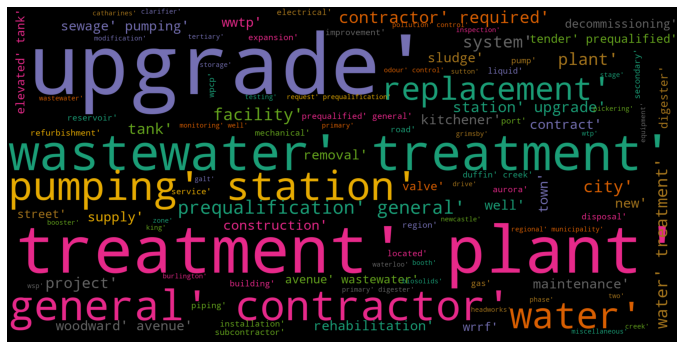

Consulting - Others


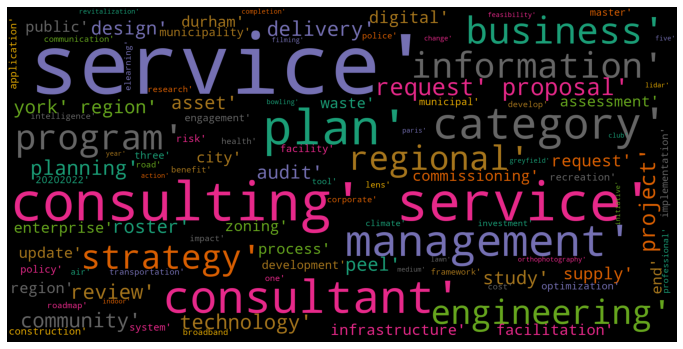

Consulting - Transportation Road/Trainsit


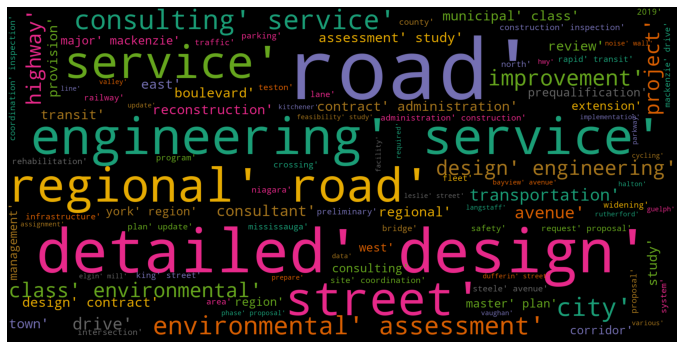

Consulting - Water Wastewater Vertical


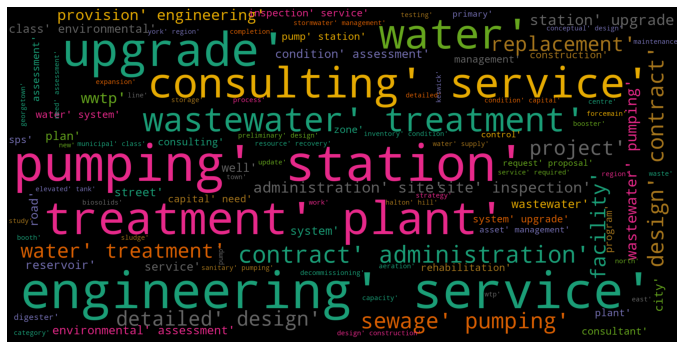

Construction - Facility


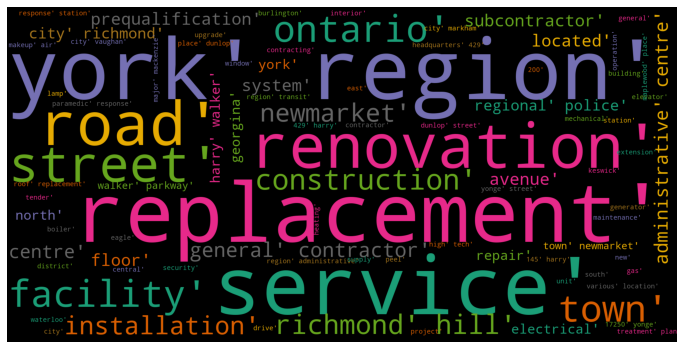

Construction - Fibre Optic Cable


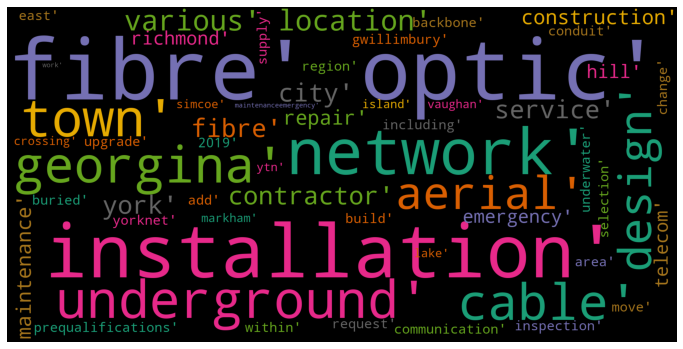

In [156]:
category_list = df.Category.unique().tolist()

# create a dict of list and pandas frames
dict_category = {}

for item in category_list:
    dict_category[item] = df[df.Category == item].project_name

for key, df_project in dict_category.items():
    print(bid_category_numbering_reverse.get(key))
    plot_wordcloud(df_project)

### 2.10 Wordcloud by type <a id='2.10'></a>

rfq


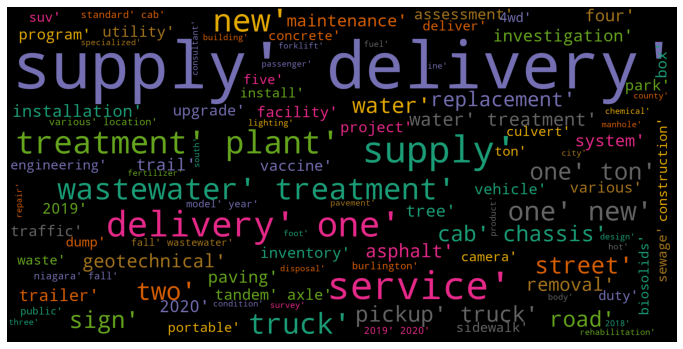

rft


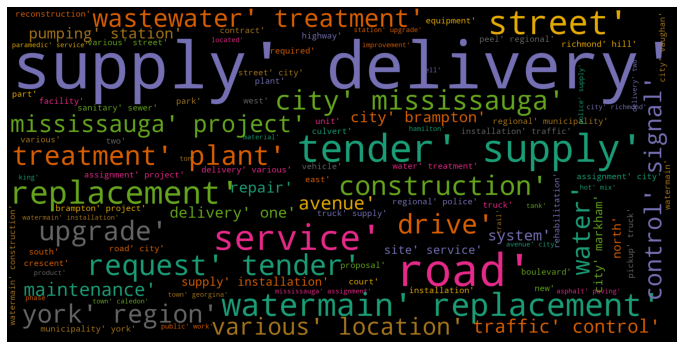

rfp


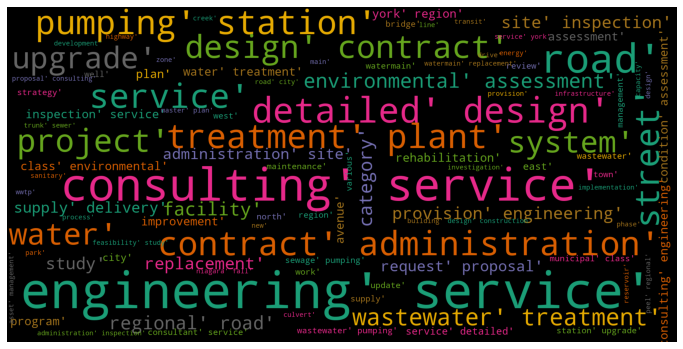

rfpq


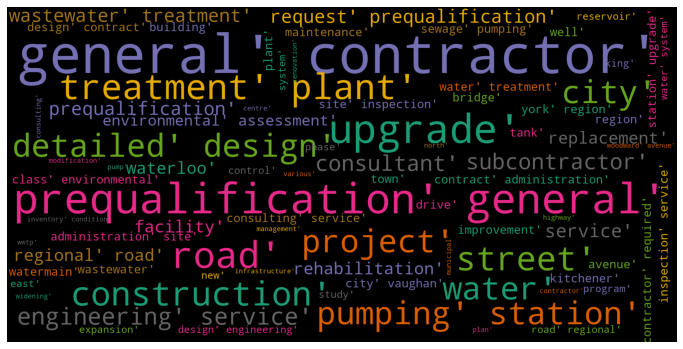

others


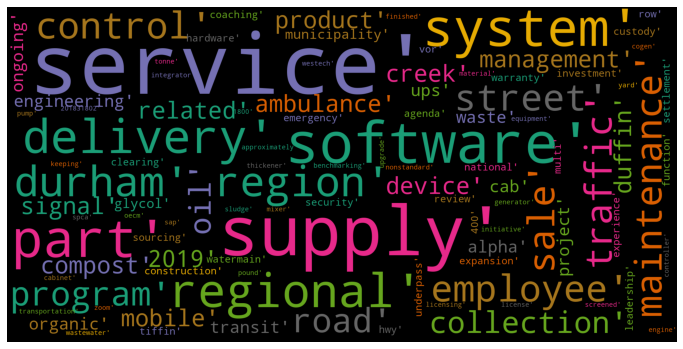

rfi


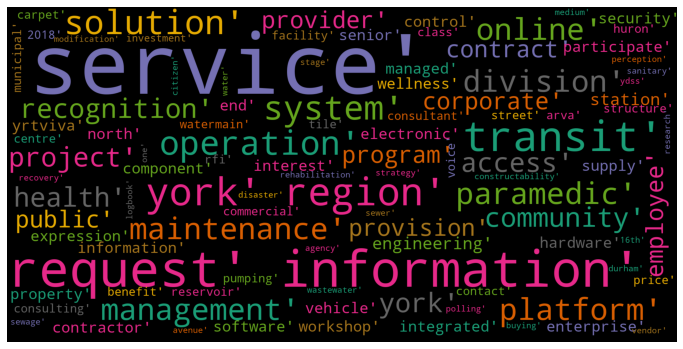

In [158]:
type_list = df.bid_type.unique().tolist()
# create a dict of list and pandas frames
dict_type = {}

for item in type_list:
    dict_type[item] = df[df.bid_type == item].project_name

for key, df_project in dict_type.items():
    print(key)
    plot_wordcloud(df_project)

## 3. Pre-processing and Training Data Development <a id='3'></a>

In [159]:
df.head()

project_name  Category bid_type
0  1 one 1 ton heavy duty 4wd cab and chassis tru...        14      rfq
1                    1 one seven 7 passenger minivan        14      rfq
2                  1 one seven 7 passenger van wagon        14      rfq
3      1 one ton 8 cyl standard cab 2wd pickup truck        14      rfq
4            1 one ton 4wd standard cab pickup truck        14      rfq

### 3.1 Lemmatization and Stopwords Removal <a id='3.1'></a>

In [160]:
# remove all stop words
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
df["project_name_non_stop"] = df["project_name"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df["project_name_non_stop_lemma"] = df["project_name_non_stop"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in (stop_words)]))

In [161]:
df["project_name_non_stop_lemma"][60:70]

105    supply installation sidewalk curb repair vario...
106    supply installation winter control equipment t...
107    supply place asphalt paving eric tomlinson pat...
108    supply place asphalt paving scotland cemetery ...
109    supply place asphalt paving burford community ...
111    supply delivery application mobile dripless co...
113    tender one 1 28000kg62000lbs gvwr tandem axle ...
114    tender one 1 single axle cab chassis diesel truck
116    widening urbanization rest acre road king edwa...
121                                ash tree removal 2021
Name: project_name_non_stop_lemma, dtype: object

In [162]:
# get targets and features
X = df[["project_name_non_stop_lemma", 'bid_type']]
y = df['Category']

In [163]:
X.shape

(2591, 2)

In [164]:
y.shape

(2591,)

In [165]:
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)
#Check the shape of each set
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2072, 2) (519, 2) (2072,) (519,)


In [166]:
X.head()

project_name_non_stop_lemma bid_type
0  1 one 1 ton heavy duty 4wd cab chassis truck s...      rfq
1                    1 one seven 7 passenger minivan      rfq
2                  1 one seven 7 passenger van wagon      rfq
3      1 one ton 8 cyl standard cab 2wd pickup truck      rfq
4            1 one ton 4wd standard cab pickup truck      rfq

In [167]:
y.head()

0    14
1    14
2    14
3    14
4    14
Name: Category, dtype: int64

#### 3.2 Pre-processing Pipeline

In [168]:
transformer = [('cat', OneHotEncoder(), ["bid_type"]),
               ('text', CountVectorizer(), "project_name_non_stop_lemma")]
preprocessor = ColumnTransformer(transformers = transformer)

## 4. Training <a id='4'></a>

### 4.1 Logistic Regression <a id='4.1'></a>

In [229]:
# define pipeline for ml model
lr_model = LogisticRegression(class_weight='balanced')
lg_pipeline = [('preprocessor', preprocessor),
               ('logisticR', lr_model)]

In [230]:
lg_pipe = Pipeline(lg_pipeline)
lg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['bid_type']),
                                                 ('text', CountVectorizer(),
                                                  'project_name_non_stop_lemma')])),
                ('logisticR', LogisticRegression(class_weight='balanced'))])

In [231]:
# make predictions
y_pred_lg = lg_pipe.predict(X_test)
y_pred_train_lg = lg_pipe.predict(X_train)

In [232]:
# accuracy score
print("Accuracy(Training): ", metrics.accuracy_score(y_train, y_pred_train_lg))
print("Accuracy(Prediction) :", metrics.accuracy_score(y_test, y_pred_lg))

Accuracy(Training):  0.9768339768339769
Accuracy(Prediction) : 0.8131021194605009


              precision    recall  f1-score   support

           1       0.64      0.75      0.69        12
           2       0.50      0.50      0.50         2
           3       0.83      0.67      0.74        15
           4       0.81      0.90      0.85        39
           5       0.97      0.84      0.90        44
           6       0.88      0.86      0.87        44
           7       0.62      0.47      0.53        17
           8       0.69      0.67      0.68        33
           9       0.34      0.65      0.45        17
          10       1.00      0.71      0.83         7
          11       0.69      0.71      0.70        38
          12       0.53      0.59      0.56        17
          13       0.81      0.81      0.81        64
          14       0.96      0.92      0.94       170

    accuracy                           0.81       519
   macro avg       0.73      0.72      0.72       519
weighted avg       0.83      0.81      0.82       519



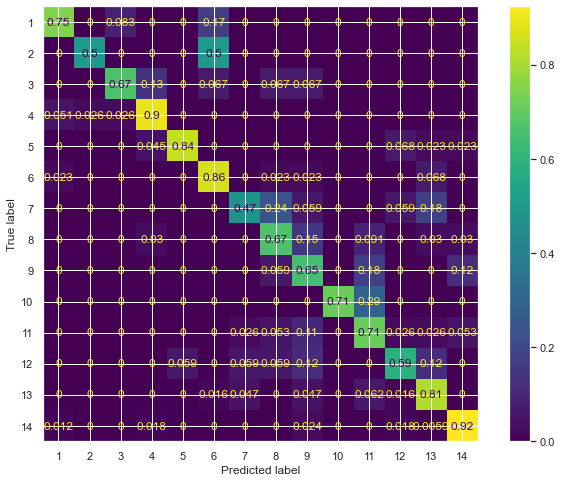

In [233]:
# draw confusion matrix
def draw_confusionmatrix(y_test_true, y_test_pred, cat_number):
    label = [i for i in range(1, cat_number+1)]
    test_confusion = metrics.confusion_matrix(y_test_true, y_test_pred, normalize = 'true')
    cmd = ConfusionMatrixDisplay(test_confusion, display_labels=label)
    cmd.plot()
    print(metrics.classification_report(y_test_true, y_test_pred))

cat_number = 14
draw_confusionmatrix(y_test, y_pred_lg, 14)

#### 4.1.1 Logistic Regression Hyperparameters Tuning - with Feature Reduction <a id='4.1.1'></a>

In [174]:
# Obtain label generated in the first step of the pipeline - 
# preprocessing (after the column transformation)
preprocessor = lg_pipe.named_steps['preprocessor']
labels = preprocessor.get_feature_names()
len(labels)

3273

In [175]:
labels[500:530]

['text__approximately',
 'text__appurtenance',
 'text__aqua',
 'text__aqueduct',
 'text__arc',
 'text__archaeological',
 'text__archaeology',
 'text__architect',
 'text__architectural',
 'text__architecturalengineering',
 'text__architecture',
 'text__archive',
 'text__arcserve',
 'text__ardill',
 'text__area',
 'text__argus',
 'text__arkell',
 'text__arlington',
 'text__arlow',
 'text__armour',
 'text__armstrong',
 'text__arrest',
 'text__art',
 'text__arthur',
 'text__articulated',
 'text__articulating',
 'text__aruba',
 'text__arva',
 'text__asbestos',
 'text__ash']

In [176]:
# create a dataframe base on the labels
X_converted = pd.DataFrame(preprocessor.transform(X_train).toarray(), columns=labels)
X_converted

cat__x0_others  cat__x0_rfi  cat__x0_rfp  cat__x0_rfpq  cat__x0_rfq  \
0                0.0          0.0          1.0           0.0          0.0   
1                0.0          0.0          1.0           0.0          0.0   
2                0.0          0.0          0.0           0.0          1.0   
3                0.0          0.0          0.0           1.0          0.0   
4                0.0          0.0          0.0           0.0          0.0   
...              ...          ...          ...           ...          ...   
2067             0.0          0.0          0.0           0.0          0.0   
2068             0.0          0.0          1.0           0.0          0.0   
2069             0.0          0.0          1.0           0.0          0.0   
2070             0.0          0.0          1.0           0.0          0.0   
2071             0.0          0.0          0.0           0.0          0.0   

      cat__x0_rft  text__01  text__02  text__027225  text__027230  ...  \
0             0.0       0.0       0.0           0.0           0.0  ...   
1             0.0       0.0       0.0           0.0           0.0  ...   
2             0.0       0.0       0.0           0.0           0.0  ...   
3             0.0       0.0       0.0           0.0           0.0  ...   
4             1.0       0.0       0.0           0.0           0.0  ...   
...           ...       ...       ...           ...           ...  ...   
2067          1.0       0.0       0.0           0.0           0.0  ...   
2068          0.0       0.0       0.0           0.0           0.0  ...   
2069          0.0       0.0       0.0           0.0           0.0  ...   
2070          0.0       0.0       0.0           0.0           0.0  ...   
2071          1.0       0.0       0.0           0.0           0.0  ...   

      text__yr83  text__yrt  text__ytn  text__zephyr  text__zero  text__zinc  \
0            0.0        0.0        0.0           0.0         0.0         0.0   
1            0.0        0.0        0.0           0.0         0.0         0.0   
2            0.0        0.0        0.0           0.0         0.0         0.0   
3            0.0        0.0        0.0           0.0         0.0         0.0   
4            0.0        0.0        0.0           0.0         0.0         0.0   
...          ...        ...        ...           ...         ...         ...   
2067         0.0        0.0        0.0           0.0         0.0         0.0   
2068         0.0        0.0        0.0           0.0         0.0         0.0   
2069         0.0        0.0        0.0           0.0         0.0         0.0   
2070         0.0        0.0        0.0           0.0         0.0         0.0   
2071         0.0        0.0        0.0           0.0         0.0         0.0   

      text__zone  text__zoning  text__zoom  text__zumro  
0            0.0           0.0         0.0          0.0  
1            0.0           0.0         0.0          0.0  
2            0.0           0.0         0.0          0.0  
3            0.0           0.0         0.0          0.0  
4            0.0           0.0         0.0          0.0  
...          ...           ...         ...          ...  
2067         0.0           0.0         0.0          0.0  
2068         0.0           0.0         0.0          0.0  
2069         0.0           0.0         0.0          0.0  
2070         0.0           0.0         0.0          0.0  
2071         0.0           0.0         0.0          0.0  

[2072 rows x 3273 columns]

In [177]:
# generate a feature importance dataframe
X_columns = X_converted.columns
lg_model = lg_pipe.named_steps['logisticR']
lg_feature_score = pd.DataFrame(lg_model.coef_[0], index=X_columns, columns=['ImportanceScore'])
lg_feature_score

ImportanceScore
cat__x0_others        -0.196369
cat__x0_rfi           -0.268038
cat__x0_rfp           -1.194819
cat__x0_rfpq           0.444766
cat__x0_rfq            0.381093
...                         ...
text__zinc            -0.001434
text__zone            -0.117642
text__zoning          -0.000140
text__zoom            -0.001152
text__zumro           -0.000658

[3273 rows x 1 columns]

In [178]:
lg_feature_score.sort_values(by = 'ImportanceScore').head(10)

ImportanceScore
cat__x0_rfp               -1.194819
text__water               -1.024679
text__watermain           -0.929495
text__engineering         -0.759719
text__inspection          -0.676053
text__consulting          -0.676040
text__pumping             -0.670512
text__bridge              -0.631956
text__municipality        -0.524865
text__housing             -0.523740

In [179]:
lg_feature_score.sort_values(by = 'ImportanceScore').tail(10)

ImportanceScore
text__roof                  0.893790
text__subcontractor         0.908615
text__region                0.939883
text__designbuild           0.966396
text__dunlop                0.996700
text__ontario               1.025198
text__structural            1.030724
text__floor                 1.093497
text__facility              1.158800
text__centre                1.346637

In [180]:
lg_feature_score.describe()

ImportanceScore
count      3273.000000
mean          0.004261
std           0.147605
min          -1.194819
25%          -0.023048
50%          -0.004963
75%          -0.001100
max           1.346637

We will select the features that are smaller than 25% and larger than 75%.

In [181]:
# select features that between 0-25% and 75% - 100% of the data (since
# they have heavier weight on the dat )
upper_bound = -0.0011
lower_bound = -0.023048

mask = (lg_feature_score['ImportanceScore'] > lower_bound) & (lg_feature_score['ImportanceScore'] < upper_bound)

lg_feature_score_lower = list(lg_feature_score.loc[mask].index)

len(lg_feature_score_lower)

1635

In [182]:
# feature selection on X_train dataset
preprocessor = preprocessor.fit(X_train)
X_train_featureS = preprocessor.transform(X_train)
X_train_featureS = pd.DataFrame.sparse.from_spmatrix(X_train_featureS)
X_train_featureS.columns = labels
X_train_featureS = X_train_featureS.drop(columns = lg_feature_score_lower)

In [183]:
X_train_featureS.shape

(2072, 1638)

In [184]:
X_train_featureS.head()

cat__x0_others  cat__x0_rfi  cat__x0_rfp  cat__x0_rfpq  cat__x0_rfq  \
0             0.0          0.0          1.0           0.0          0.0   
1             0.0          0.0          1.0           0.0          0.0   
2             0.0          0.0          0.0           0.0          1.0   
3             0.0          0.0          0.0           1.0          0.0   
4             0.0          0.0          0.0           0.0          0.0   

   cat__x0_rft  text__027225  text__027230  text__03  text__038205  ...  \
0          0.0           0.0           0.0       0.0           0.0  ...   
1          0.0           0.0           0.0       0.0           0.0  ...   
2          0.0           0.0           0.0       0.0           0.0  ...   
3          0.0           0.0           0.0       0.0           0.0  ...   
4          1.0           0.0           0.0       0.0           0.0  ...   

   text__young  text__yr  text__yr38  text__yr49  text__yr67  text__yrt  \
0          0.0       0.0         0.0         0.0         0.0        0.0   
1          0.0       0.0         0.0         0.0         0.0        0.0   
2          0.0       0.0         0.0         0.0         0.0        0.0   
3          0.0       0.0         0.0         0.0         0.0        0.0   
4          0.0       0.0         0.0         0.0         0.0        0.0   

   text__zephyr  text__zone  text__zoning  text__zumro  
0           0.0         0.0           0.0          0.0  
1           0.0         0.0           0.0          0.0  
2           0.0         0.0           0.0          0.0  
3           0.0         0.0           0.0          0.0  
4           0.0         0.0           0.0          0.0  

[5 rows x 1638 columns]

In [185]:
# Hyperparameters tunning for LR model
model = LogisticRegression(class_weight='balanced', max_iter=1000)
solvers = ['newton-cg', 'lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_featureS, y_train)

In [186]:
lg_best = grid_result.best_estimator_

In [187]:
grid_result.best_score_

0.7997329059829059

The result shows that feature reduction combining with model hyperparameters did not improve the model. We will try only hyperparameters on the original dataset.

#### 4.1.2 Logistic Regression Hyperparameters Tuning - without Feature Reduction <a id='4.1.2'></a>

In [188]:
# repeat the steps above without removing features
preprocessor = preprocessor.fit(X_train)
X_train_featureA = preprocessor.transform(X_train)
X_train_featureA = pd.DataFrame.sparse.from_spmatrix(X_train_featureA)
model = LogisticRegression(class_weight='balanced', max_iter=3000)
solvers = ['newton-cg', 'lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_featureA, y_train)

grid_result.best_score_

0.8111474978322804

In [189]:
X_test_featureA = preprocessor.transform(X_test)
X_test_featureA = pd.DataFrame.sparse.from_spmatrix(X_test_featureA)

lg_bestModel = grid_result.best_estimator_
y_pred_train = lg_bestModel.predict(X_train_featureA)
y_pred_real = lg_bestModel.predict(X_test_featureA)

In [190]:
# accuracy score
print("Accuracy(Training): ", metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy(Prediction) :", metrics.accuracy_score(y_test, y_pred_real))

Accuracy(Training):  0.9980694980694981
Accuracy(Prediction) : 0.8188824662813102


              precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.50      0.50      0.50         2
           3       0.83      0.67      0.74        15
           4       0.83      0.90      0.86        39
           5       0.95      0.86      0.90        44
           6       0.88      0.86      0.87        44
           7       0.58      0.41      0.48        17
           8       0.72      0.70      0.71        33
           9       0.37      0.65      0.47        17
          10       1.00      0.71      0.83         7
          11       0.74      0.74      0.74        38
          12       0.53      0.53      0.53        17
          13       0.78      0.84      0.81        64
          14       0.96      0.92      0.94       170

    accuracy                           0.82       519
   macro avg       0.74      0.72      0.72       519
weighted avg       0.83      0.82      0.82       519



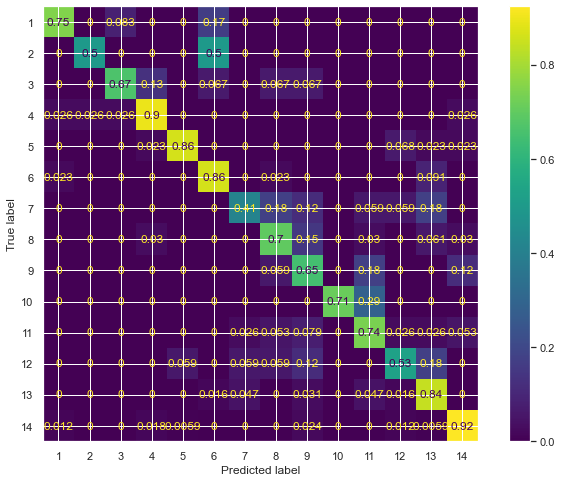

In [191]:
cat_number = 14
draw_confusionmatrix(y_test, y_pred_real, 14)

Only slight improvement observed using logistic regression model with conditions of using/not using feature selection when doing hyperparameter turning.

### 4.2 Random Forest Model <a id='4.2'></a>

In [192]:
# define pipeline for ml model - random forest
rf_pipeline = [('preprocessor', preprocessor),
            ('randomF', RandomForestClassifier(class_weight='balanced'))]

In [193]:
# data training
rf_pipe = Pipeline(rf_pipeline)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['bid_type']),
                                                 ('text', CountVectorizer(),
                                                  'project_name_non_stop_lemma')])),
                ('randomF', RandomForestClassifier(class_weight='balanced'))])

In [194]:
# make predictions
y_pred_rf = rf_pipe.predict(X_test)
y_pred_rf_train = rf_pipe.predict(X_train)

In [195]:
# accuracy score
print("Accuracy(Training): ", metrics.accuracy_score(y_train, y_pred_rf_train))
print("Accuracy(Prediction) :", metrics.accuracy_score(y_test, y_pred_rf))

Accuracy(Training):  0.9995173745173745
Accuracy(Prediction) : 0.7938342967244701


              precision    recall  f1-score   support

           1       1.00      0.50      0.67        12
           2       0.50      0.50      0.50         2
           3       0.89      0.53      0.67        15
           4       0.75      0.92      0.83        39
           5       0.90      0.82      0.86        44
           6       0.88      0.86      0.87        44
           7       0.78      0.41      0.54        17
           8       0.67      0.61      0.63        33
           9       0.38      0.53      0.44        17
          10       1.00      0.86      0.92         7
          11       0.58      0.68      0.63        38
          12       0.50      0.29      0.37        17
          13       0.74      0.80      0.77        64
          14       0.92      0.96      0.94       170

    accuracy                           0.79       519
   macro avg       0.75      0.66      0.69       519
weighted avg       0.80      0.79      0.79       519



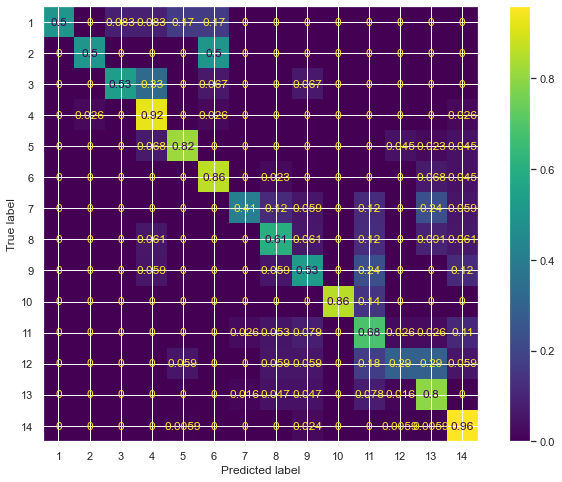

In [196]:
cat_number = 14
draw_confusionmatrix(y_test, y_pred_rf, 14)

#### 4.2.1 Random Forest Model Hyperparameters Tuning  <a id='4.2.1'></a>

In [197]:
# Conduct all steps in preprocessing
preprocessor_rf = rf_pipe.named_steps['preprocessor']
X_train_rf = preprocessor_rf.fit(X_train)
X_train_rf = preprocessor_rf.transform(X_train)
model_rf = RandomForestClassifier(class_weight='balanced')

X_test_rf = preprocessor_rf.transform(X_test)

In [198]:
# grid search parameters
bootstrap = [True, False]
max_depth = [5, 25, 50, 80, 90, 100, 110, 1000]
n_estimators = [50, 100, 300, 400, 500]
min_samples_split = [2, 3, 4 , 6]

param_grid = dict(bootstrap=bootstrap, max_depth=max_depth,
                  n_estimators=n_estimators, min_samples_split=min_samples_split)

In [199]:
# grid search
rf_gridsearch = GridSearchCV(model_rf, param_grid, n_jobs=-1, cv=3)
rf_gridsearch.fit(X_train_rf, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 25, 50, 80, 90, 100, 110, 1000],
                         'min_samples_split': [2, 3, 4, 6],
                         'n_estimators': [50, 100, 300, 400, 500]})

In [200]:
rf_gs_best = rf_gridsearch.best_estimator_
rf_gridsearch.best_score_

0.789577521899928

In [201]:
y_pred_train = rf_gs_best.predict(X_train_rf)
y_pred_test = rf_gs_best.predict(X_test_rf)

In [202]:
# accuracy score
print("Accuracy(Training): ", metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy(Prediction) :", metrics.accuracy_score(y_test, y_pred_test))

Accuracy(Training):  0.9956563706563707
Accuracy(Prediction) : 0.7938342967244701


## 5. Modeling  <a id='5'></a>

In [242]:
best_model = lg_pipe


project_name = "consulting service for wastewater treatment plant"
X_sample = pd.DataFrame({"project_name_non_stop_lemma": [project_name],
                        "bid_type": 'rfp'})
X_sample

project_name_non_stop_lemma bid_type
0  consulting service for wastewater treatment plant      rfp

In [245]:
bid_category_numbering_reverse.get(best_model.predict(X_sample)[0])


'Consulting - Water Wastewater Vertical'

The result is correct!

## 6. Conclusion <a id='6'></a>

Both the default random forest and logistic regression models shows better performance than the hyperparameters tuning models. Note that the performance of default models provided decent results for 8 out of 14 categories, due to this performance, this trial study will end now. Below please find the notes on conclusions and recommendations.

Based on the dataset, we can make the follow remarks on the performance of the model:
1. Not enough data and biased data: we only have around 2591 data points and 14 categories. On average, each category would have 185 data points, but our data is biased because of the following points: category 14 has over 800 data points. Other than category 14, only 5 categories have over 200 data points. All the rest categories have data points less than 100. This may contribute to poor model performance. After all, all data points were marked manual, it was a labor intense activity.

2. WordCLoud proves that more work is required for keywords removing: words such as York (known as "York" from the "York Region"), city, region, township essentially can be scattered in all project names, but they are considered to be frequent in some of the categories. They may screw some data points over.
For future works, it is recommended to increase more data points and perform one more data cleaning base on wordcloud results.